In [10]:
import tensorflow as tf
import keras
import os
import shutil
import cv2
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
from keras.models import load_model

In [25]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [28]:
import splitfolders
import os
path = "Testing"
print(os.listdir(path))
splitfolders.ratio(path,seed=123, output="Evaluation", ratio=(0.7,0.3))

['glioma', 'meningioma', 'notumor', 'pituitary']


Copying files: 1311 files [00:00, 1652.90 files/s]


In [29]:
print(len(glob.glob("Evaluation/Test/**/*.jpg")))
print(len(glob.glob("Evaluation/Validation/**/*.jpg")))

394
917


In [30]:
train_dir = "Training"
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    interpolation='area'
)

valid_dir = "Evaluation/Validation"
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    interpolation='area'
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [31]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


# Load VGG16

In [32]:
model = tf.keras.Sequential()

vgg16_base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
)

for layer in vgg16_base.layers:
    layer.trainable=False


model.add(vgg16_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [33]:
import segmentation_models_3D as sm
focal_loss = sm.losses.CategoricalFocalLoss()

In [35]:
epochs = 10
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=focal_loss,
              metrics=['accuracy'])

checkpoint =  tf.keras.callbacks.ModelCheckpoint(filepath ='model_checkpoints/vgg16_focal_loss.hdf5',
                                                 verbose=1,
                                                 )

# Define some callbacks to improve training.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)


In [36]:
history_vgg16 = model.fit(train_ds,
                          validation_data=val_ds,
                          epochs=epochs,
                          callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/10
357/357 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.8430
Epoch 1: saving model to model_checkpoints\vgg16_focal_loss.hdf5
357/357 [==============================] - 54s 150ms/step - loss: 0.0108 - accuracy: 0.8430 - val_loss: 0.0057 - val_accuracy: 0.9001 - lr: 1.0000e-04
Epoch 2/10
357/357 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9357
Epoch 2: saving model to model_checkpoints\vgg16_focal_loss.hdf5
357/357 [==============================] - 54s 150ms/step - loss: 0.0036 - accuracy: 0.9357 - val_loss: 0.0034 - val_accuracy: 0.9413 - lr: 1.0000e-04
Epoch 3/10
357/357 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9597
Epoch 3: saving model to model_checkpoints\vgg16_focal_loss.hdf5
357/357 [==============================] - 54s 150ms/step - loss: 0.0023 - accuracy: 0.9597 - val_loss: 0.0029 - val_accuracy: 0.9458 - lr: 1.0000e-04
Epoch 4/10
357/357 [==============================] - ETA: 0s - 

In [38]:
valid_dir = "Evaluation/Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    interpolation='area'
)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
score = model.evaluate(test_ds)

Found 1311 files belonging to 4 classes.
82/82 [==============================] - 10s 120ms/step - loss: 0.0013 - accuracy: 0.9718


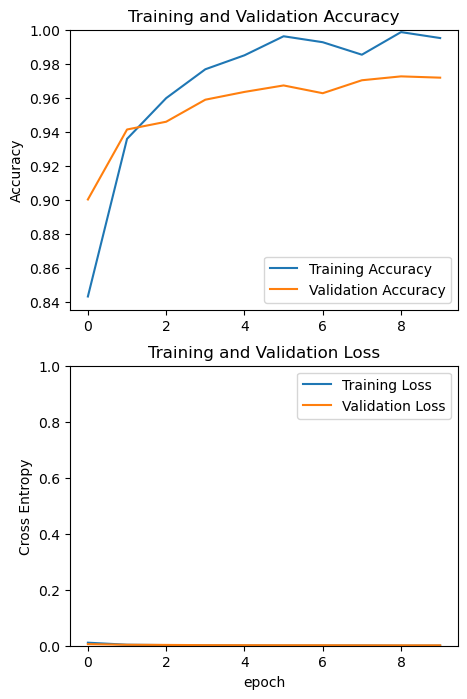

In [39]:
history = history_vgg16
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(5,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
for img_batch, label_batch in test_set:
    